# Actor Critic Methods

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as distributions
import torch.multiprocessing as mp

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
class Actor(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims, lr):
        super(Actor, self).__init__()
        self.input_layer = nn.Linear(input_dims, hidden_dims[0])
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dims[i], hidden_dims[i+1]) for i in range(len(hidden_dims) - 1)]
        )
        self.output_layer = nn.Linear(hidden_dims[-1], output_dims)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.to(device)
        
    def forward(self, state):
        x = torch.tensor(state, dtype=torch.float32).to(device)
        x = F.relu(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        x = self.output_layer(x)
        return x
    
    def step(self, state):
        logits = self.forward(state)
        distribution = distributions.Categorical(logits=logits)
        actions = distribution.sample()
        log_probs = distribution.log_prob(actions)
        entropies = distribution.entropy()
        return actions, log_probs, entropies

In [4]:
class Critic(nn.Module):
    def __init__(self, input_dims, hidden_dims, lr):
        super(Critic, self).__init__()
        self.input_layer = nn.Linear(input_dims, hidden_dims[0])
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dims[i], hidden_dims[i+1]) for i in range(len(hidden_dims) - 1)]
        )
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.to(device)
        
    def forward(self, state):
        x = torch.tensor(state, dtype=torch.float32).to(device)
        x = F.relu(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        x = self.output_layer(x)
        return x
    
    def calculate_value(self, state):
        with torch.no_grad():
            x = torch.tensor(state, dtype=torch.float32).to(device)
            x = F.relu(self.input_layer(x))
            for hidden_layer in self.hidden_layers:
                x = F.relu(hidden_layer(x))
            x = self.output_layer(x)
            return x

In [5]:
# A combined actor-critic network
class ActorCritic(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims, lr):
        super(ActorCritic, self).__init__()
        self.input_layer = nn.Linear(input_dims, hidden_dims[0])
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dims[i], hidden_dims[i+1]) for i in range(len(hidden_dims) - 1)]
        )
        self.actor_output_layer = nn.Linear(hidden_dims[-1], output_dims)
        self.critic_output_layer = nn.Linear(hidden_dims[-1], 1)
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.to(device)
    
    def forward(self, state):    
        x = torch.tensor(state, dtype=torch.float32).to(device)
        x = F.relu(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        actor_output = self.actor_output_layer(x)
        critic_output = self.critic_output_layer(x)
        return actor_output, critic_output
    
    def step(self, state):
        logits, value = self.forward(state)
        distribution = distributions.Categorical(logits=logits)
        action = distribution.sample()
        log_prob = distribution.log_prob(action)
        entropy = distribution.entropy()
        return action.cpu().item(), log_prob, entropy, value

In [6]:
class ChildEnv(gym.Env):
    def __init__(self, env_name, seed, conn):
        self.conn = conn
        self.env = gym.make(env_name)
        self.env.seed(seed)

    def listen(self):
        while True:
            cmd, action = self.conn.recv()
            if cmd == 'reset':
                self.conn.send(self.reset())
                
            if cmd == 'step':
                self.conn.send((self.step(action)))
                
            if cmd == 'close':
                self.close()
                break

    def reset(self):
        return self.env.reset()

    def step(self, action):
        return self.env.step(action)
    
    def close(self):
        self.env.close()
        del self.env
        self.conn.close()
        del self.conn
        
        
class ParentEnv(gym.Env):
    def __init__(self, env_name, n_processes):
        self.n_processes = n_processes
        
        self.connections = [mp.Pipe() for process in range(n_processes)]
        self.children = [
            mp.Process(target=self.control_child, args=(env_name, process, self.connections[process][1])) \
                for process in range(n_processes)]
        
        for child in self.children:
            child.start()
            
    def control_child(self, env_name, seed, conn):
        child = ChildEnv(env_name, seed, conn)
        child.listen()
    
    def step(self, actions):
        results = []
        for seed, connection in enumerate(self.connections):
            connection[0].send(('step', actions[seed]))
            
        for connection in self.connections:
            obs, reward, done, info = connection[0].recv()
            if done == True:
                is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
                connection[0].send(('reset', ''))
                obc = connection[0].recv()
                if is_truncated:
                    done = False
            results.append([obs, reward, done, info])
            
        return [np.vstack(part) for part in np.array(results).T]
    
    def close(self):
        for connection in self.connections:
            connection[0].send(('close', ''))
    
    def reset(self):
        observations = []
        for connection in self.connections:
            connection[0].send(('reset', ''))
        
        for connection in self.connections:
            observation = connection[0].recv()
            observations.append(observation)
            
        return np.array(observations)

In [7]:
class Agent():
    def __init__(self, 
                 state_dims, 
                 actor_hidden_dims, 
                 critic_hidden_dims, 
                 action_dims, 
                 gamma, 
                 beta,
                 tau,
                 actor_lr,
                 critic_lr):
        self.actor = Actor(
            input_dims=state_dims, 
            hidden_dims=actor_hidden_dims, 
            output_dims=action_dims, 
            lr=actor_lr)
        self.critic = Critic(
            input_dims=state_dims,
            hidden_dims=critic_hidden_dims,
            lr=critic_lr
        )
        self.gamma = gamma
        self.beta = beta
        self.tau = tau
        self.reset()
        
    def reset(self):
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.entropies = []
    
    def learn(self):
        trajectory_len = len(self.rewards)
        gammas = np.array([self.gamma**i for i in range(trajectory_len)], dtype=np.float32)
        taus = np.array([(self.gamma * self.tau)**i for i in range(trajectory_len)], dtype=np.float32) 
        
        returns = [[np.sum(np.array(self.rewards)[t:, worker] * gammas[:trajectory_len - t]) 
                   for t in range(trajectory_len)]
                   for worker in range(len(self.rewards[0]))]
                
        #shape will be after transforms (workers (batches), n-steps)
        #print(returns.shape)
        returns = torch.tensor(returns, dtype=torch.float32).to(device)
        log_probs = torch.vstack(self.log_probs).squeeze(1).T
        values = torch.vstack(self.values).squeeze(1).T
        entropies = torch.vstack(self.entropies).squeeze(1).T
        taus = torch.tensor(taus, dtype=torch.float32).to(device)
        
        advantages = returns + self.gamma * values[:,1:] - values[:, :-1]


        gaes = torch.tensor([[torch.sum(advantages[worker, t:] * taus[:trajectory_len - t] ) 
                for t in range(trajectory_len)]
                for worker in range(len(self.rewards[0]))])
                        
        actor_loss = -(gaes.detach() * log_probs + self.beta * entropies).mean()
        
        self.actor.optimizer.zero_grad()
        actor_loss.backward()
        self.actor.optimizer.step()
        

        critic_advantages = returns - values[:, :-1]
        critic_loss = critic_advantages.pow(2).mul(0.5).mean()
        self.critic.optimizer.zero_grad()
        critic_loss.backward()
        self.critic.optimizer.step()
        
        self.reset()
    
    def add_rewards(self, rewards):
        self.rewards.append(rewards)
    
    def act(self, states):
        actions, log_probs, entropies = self.actor.step(states)
        self.log_probs.append(log_probs)
        self.entropies.append(entropies)
        self.values.append(self.critic(states).squeeze(1))
        return actions.cpu().numpy()
    
    
    def values_from_state(self, states):
        self.values.append(self.critic.calculate_value(states).squeeze(1))
    
    
    def choose_action(self, states):
        with torch.no_grad():
            actions, _, _ = self.actor.step(states)
            return actions.item()

In [8]:
# parameters
env_name = 'CartPole-v1'
steps = 100000
actor_alpha = 0.0005
critic_alpha = 0.0008
beta = 0.001
gamma = 0.99
tau = 0.95
actor_hidden_dims = (128, 64)
critic_hidden_dims = (256, 64)
win_condition = 475
n_steps = 10

In [9]:
# main loop
eval_env = gym.make(env_name)
state_dims = eval_env.observation_space.shape[0]
action_dims = eval_env.action_space.n

env = ParentEnv(env_name, 8)
agent = Agent(state_dims, 
                  actor_hidden_dims, 
                  critic_hidden_dims, 
                  action_dims, 
                  gamma, 
                  beta,
                  tau,
                  actor_alpha,
                  critic_alpha)
track_rewards_mean = []
track_rewards = []
best_mean = -10000
episode = 0
obss = env.reset()
for step in range(steps):

    action = agent.act(obss)
    new_obss, rewards, dones, _ = env.step(action)
    agent.add_rewards(rewards)
    obss = new_obss
        
    if (step + 1) % n_steps == 0 or dones.sum():
        agent.values_from_state(new_obss)
        agent.learn()
    
        if step > 1000:
            eval_obs, eval_done = eval_env.reset(), False
            reward_sum = 0
            while not eval_done:
                eval_action = agent.choose_action(eval_obs)
                new_eval_obs, eval_reward, eval_done, _ = eval_env.step(eval_action)
                eval_obs = new_eval_obs
                reward_sum += eval_reward
            track_rewards.append(reward_sum)
            episode += 1
            if episode > 100:
                mean = np.mean(track_rewards[-100:])
                if mean > best_mean:
                    best_mean = mean
                track_rewards_mean.append(mean)
                print(f'Step: {step}, Episode: {episode}, Current Rewards: {reward_sum}, Reward Mean: {mean}, Best Mean: {best_mean}', end='\r')
                if mean > win_condition:
                    env.close()
                    break
    

<ipython-input-6-a36c8de3725c>:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return [np.vstack(part) for part in np.array(results).T]


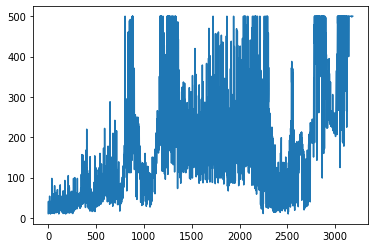

In [10]:
plt.plot(track_rewards)
plt.show()

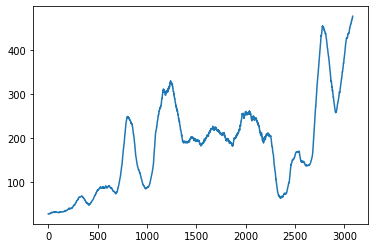

In [11]:
plt.plot(track_rewards_mean)
plt.show()